### Задание 2  
Реализуйте базовую модель логистической регрессии для классификации текстовых сообщений (используемые данные https://github.com/obulygin/pyda_homeworks/blob/master/stat_case_study/spam.csv) по признаку спама. Для этого:

1) Привидите весь текст к нижнему регистру;  
2) Удалите мусорные символы;  
3) Удалите стоп-слова;  
4) Привидите все слова к нормальной форме;  
5) Преобразуйте все сообщения в вектора TF-IDF. Вам поможет следующий код:

from sklearn.feature_extraction.text import TfidfVectorizer  
tfidf = TfidfVectorizer()  
tfidf_matrix = tfidf.fit_transform(df.Message)  
names = tfidf.get_feature_names()  
tfidf_matrix = pd.DataFrame(tfidf_matrix.toarray(), columns=names)  
Можете поэкспериментировать с параметрами TfidfVectorizer;  

6) Разделите данные на тестовые и тренировочные в соотношении 30/70, укажите random_state=42. Используйте train_test_split;  
7) Постройте модель логистической регрессии, укажите random_state=42, оцените ее точность на тестовых данных;  
8) Опишите результаты при помощи confusion_matrix;  
9) Постройте датафрейм, который будет содержать все исходные тексты сообщений, классифицированные неправильно (с указанием фактического и предсказанного).

In [15]:
import pandas as pd
import numpy as np
import re

In [16]:
df = pd.read_csv('spam.csv')
df.info()
df.sample(3)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Category  5572 non-null   object
 1   Message   5572 non-null   object
dtypes: object(2)
memory usage: 87.2+ KB


,Category,Message
4059,ham,Hi di is yijue we're meeting at 7 pm at esapla...
4705,ham,Yar but they say got some error.
1879,ham,I AM AT A PARTY WITH ALEX NICHOLS


In [17]:
# приведем все слова к нижнему регистру
df['Message']= df['Message'].str.lower()
# проверим
df.head(3)

,Category,Message
0,ham,"go until jurong point, crazy.. available only ..."
1,ham,ok lar... joking wif u oni...
2,spam,free entry in 2 a wkly comp to win fa cup fina...


In [18]:
# уберем все служебные символы
df['Message'] = df['Message'].map(lambda x: re.sub('[\W_]+',' ', x))
# проверим
df.sample(3)

,Category,Message
1922,ham,no current and food here i am alone also
1192,ham,come to my home for one last time i wont do an...
1348,ham,she doesnt need any test


In [19]:
# разделим все на слова
df['Message'] = df['Message'].map(lambda x: x.split())
df['Len List'] = df['Message'].str.len()
df.sample(3)

,Category,Message,Len List
1971,ham,"[nvm, it, s, ok]",4
75,ham,"[i, am, waiting, machan, call, me, once, you, ...",9
5471,ham,[yup],1


In [20]:
# Сколько всего получилось слов?
print(df['Len List'].sum())

90299


In [21]:
#Удалим стоп слова 
import nltk
from nltk.corpus import stopwords
stopwords_set = set(stopwords.words('english'))

In [30]:
df['Message'] = df['Message'].map(lambda x: [word for word in x if word not in stopwords_set] )
df['Len List'] = df['Message'].str.len()
df.iloc[[75]]

,Category,Message,Len List
75,ham,"[waiting, machan, call, free]",4


In [23]:
# Сколько стало слов после чистки стопслов?
print(df['Len List'].sum())

53361


In [24]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\vagin\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [32]:
# Приведем слова к нормальной форме - лемматизация 
import nltk
from nltk.stem import WordNetLemmatizer

In [35]:
lematize_word = WordNetLemmatizer()
df['Message'] = df['Message'].map(lambda x: [lematize_word.lemmatize(word) for word in x] )
df.iloc[[75]]

,Category,Message,Len List
75,ham,"[waiting, machan, call, free]",4


In [36]:
# Преобразуем полученные списки обратно в строки
def list_to_string(line):
    return ' '.join([x for x in line])
df['Message'] = df['Message'].apply(list_to_string)
df.head(3)

,Category,Message,Len List
0,ham,go jurong point crazy available bugis n great ...,16
1,ham,ok lar joking wif u oni,6
2,spam,free entry 2 wkly comp win fa cup final tkts 2...,25


In [37]:
# Преобразуем сообщения в вектора TF-IDF.

from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer()
tfidf_matrix = tfidf.fit_transform(df['Message'])
names = tfidf.get_feature_names()
tfidf_matrix = pd.DataFrame(tfidf_matrix.toarray(), columns=names)
tfidf_matrix.iloc[[2]]

,00,000,000pes,008704050406,0089,0121,01223585236,01223585334,0125698789,02,...,zhong,zindgi,zoe,zogtorius,zoom,zouk,zyada,èn,ú1,〨ud
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [38]:
# Разделяем выборку на тренировочную и тестовую
from sklearn.model_selection import train_test_split

target = df['Category'].to_numpy()

X_train, X_test, y_train, y_test = train_test_split(tfidf_matrix, target, test_size=0.30, random_state=42)

In [39]:
# Построим модель Логистической Регрессии 
# https://www.introspective-mode.org/logistic-regression-or-discriminant-function-analysis/
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(random_state=42)
lr.fit(X_train, y_train)
y_predicted = lr.predict(X_test)

In [40]:
# Проверим точность прогноза 
from sklearn.metrics import accuracy_score
accuracy_score(y_test, y_predicted)

0.958732057416268

In [80]:
# Проверим выборочно разницу факта и прогноза
columns = ['Actual', 'Predicted']
result = pd.DataFrame([y_test, y_predicted]).T
result.columns = columns
result.sample(10)

,Actual,Predicted
859,ham,ham
730,spam,spam
71,ham,ham
589,ham,ham
1079,ham,ham
140,ham,ham
1300,ham,ham
173,ham,ham
1422,ham,ham
516,ham,ham


In [42]:
# Посмотрим точность с помощью матрицы ошибок
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import numpy as np

In [43]:
confusion_matrix(y_test, y_predicted)

array([[1445,    3],
       [  66,  158]], dtype=int64)

In [44]:
tn, fp, fn, tp = confusion_matrix(y_test, y_predicted).ravel()
(tn, fp, fn, tp)

(1445, 3, 66, 158)

In [45]:
# Отрисовка с помощью дф pandas
df_confusion = pd.crosstab(y_test, y_predicted, rownames=['Actual'], colnames=['Predicted'], margins=True)
df_confusion

Predicted,ham,spam,All
Actual,,,
ham,1445,3,1448
spam,66,158,224
All,1511,161,1672


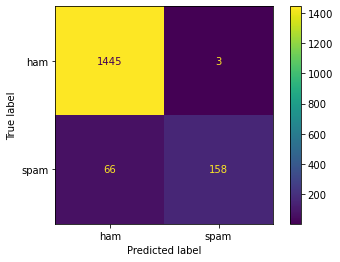

In [46]:
plot_confusion_matrix(lr, X_test, y_test)  
plt.show()  

In [47]:
print(classification_report(y_test, y_predicted, target_names=['ham', 'spam']))

              precision    recall  f1-score   support

         ham       0.96      1.00      0.98      1448
        spam       0.98      0.71      0.82       224

    accuracy                           0.96      1672
   macro avg       0.97      0.85      0.90      1672
weighted avg       0.96      0.96      0.96      1672



TN (истинно отрицательный) = 1445 - Прогноз отрицательный и это правда   
FN (ложноотрицательный) = 66  Прогноз отрицательный и это не верно.   
TP (истинно положительный результат) = 158 - Прогноз положительный и это правда .  
FP (ложноположительный результат) = 3 - Прогноз положительный но это не верно .  

Исходя из данных матрицы ошибок:
- Точность (Доля объектов действительно принадлежащих данному классу относительно всех объектов которые система отнесла к этому классу.) - 96%
- Доля ошибок  - 4%
- Полнота (Доля истинно положительных классификаций. Полнота показывает, какую долю объектов, реально относящихся к положительному классу, мы предсказали верно) - 71%

9) Постройте датафрейм, который будет содержать все исходные тексты сообщений, классифицированные неправильно (с указанием фактического и предсказанного).

In [94]:
true_df = pd.DataFrame(y_test, columns=['Category']) # Создаем дф с реальными значениями
pred_df = pd.DataFrame(y_predicted, index=y_test_concat.index, columns=['False_category'])# Создаем дф с предсказанными значениями по индексу реальных значений 
errors_df = pred_df.loc[pred_df['False_category'] != true_df['Category']] # Создаем дф с ошибочными предсказаниями 
result_df = df.merge(errors_df['False_category'], how='inner', left_index=True, right_index=True) # Создаем дф склеиванием основного дф и дф с ошибочными значениями 

,Category,Message,Len List,False_category
17,ham,eh u remember 2 spell name yes v naughty make ...,12,spam
40,ham,pls go ahead watt wanted sure great weekend ab...,9,ham
47,ham,fair enough anything going,4,ham
74,ham,u call,2,ham
84,ham,yup next stop,3,ham
...,...,...,...,...
1525,ham,hi ct employee,3,ham
1567,ham,late,1,ham
1569,ham,today accept day u accept brother sister lover...,21,ham
1576,ham,sound gd haha wah u yan jiu fast liao,9,spam


In [95]:
# Присланный Вами вариант не работает 
pred_df = pd.DataFrame(lr.predict(X_test), index=y_test.index, columns=['false_category'])
errors_df = pred_df.join(y_test).loc[pred_df.join(y_test)['false_category']!=pred_df.join(y_test)['Category']]
result = spam.merge(errors_df['false_category'], how='inner', left_index=True, right_index=True)

AttributeError: 'numpy.ndarray' object has no attribute 'index'